In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
%matplotlib inline
import torch
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import time

<ipython-input-5-88716e25256b>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [6]:
# A helper function to move various types of objects to a device
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device,
              results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        #print(f'input shape {inputs.shape}')

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func,
                                      device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device,
                          results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [7]:
import torch.nn as nn
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.455560,0.692007,0.671118,0.500000,0.500,0.666667,0.666667
1,1,0.860533,0.645732,0.631659,0.661000,0.790,0.746589,0.815789
2,2,1.260339,0.602299,0.593991,0.822750,0.815,0.837161,0.819512
3,3,1.648968,0.558784,0.557087,0.824875,0.805,0.830408,0.804020
4,4,2.035286,0.515080,0.522049,0.828250,0.815,0.830913,0.812183
5,5,2.426463,0.472921,0.490765,0.830750,0.815,0.831550,0.812183
6,6,2.809551,0.434507,0.464834,0.835000,0.815,0.835082,0.812183
7,7,3.179507,0.401404,0.444741,0.839750,0.810,0.839750,0.806122
8,8,3.556786,0.373980,0.429942,0.843875,0.810,0.843621,0.806122
9,9,3.959062,0.351693,0.419405,0.849500,0.810,0.848782,0.806122


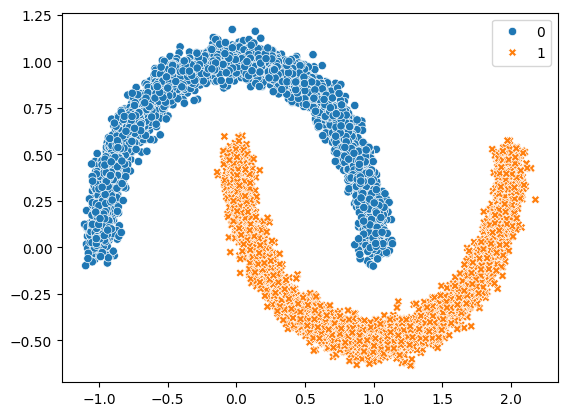

In [8]:
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

X, y = make_moons(n_samples=8000, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

X_test, y_test = make_moons(n_samples=200, noise=0.4)

classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset, batch_size=32,shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
testing_loader = DataLoader(test_dataset)

in_features = 2
out_features = 2
model = model_gd
#model = nn.Linear(in_features,out_features)
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50, device="cpu",
                     test_loader=testing_loader, score_funcs={'Acc':accuracy_score,'F1': f1_score})